In [1]:
# install machine gnostics
# recommended to run in a new virtual environment

# !pip install machinegnostics #<-- Uncomment this line to install the package

# Gnostic Boosting Regressor

### **Overview**
The **Machine Gnostics Boosting Regressor** leverages the predictive power of Gradient Boosting (XGBoost) while ensuring robustness against outliers through **Gnostic Weighted Learning**.

Gradient boosting is highly effective at minimizing loss, but standard loss functions (like MSE) are sensitive to outliers. The Gnostic variant iteratively identifies these outliers—samples that are thermodynamically inconsistent with the majority—and down-weights them, allowing the boosting model to focus on the true signal.

Key advantages:
- **State-of-the-Art Precision**: Extends XGBoost for high-performance regression.
- **Robustness**: Ignored extreme outliers that would skew standard models.
- **Gnostic Diagnostics**: Provides interpretable weights indicating sample reliability.
- **Iterative Improvement**: Refines the model through the Ideal Gnostic Cycle.

---

### **Theoretical Background**

The algorithm follows this cycle:
1.  **Boosting Step**: An XGBoost regressor minimizes error on the current weighted dataset.
2.  **Gnostic Step**: Residuals are analyzed to compute Gnostic Entropy. High entropy (unexpectedly large error) leads to lower sample probability weights.
3.  **Update**: Weights are updated, and the boosting model is retrained (or refined) to fit the "clean" data distribution better.

***

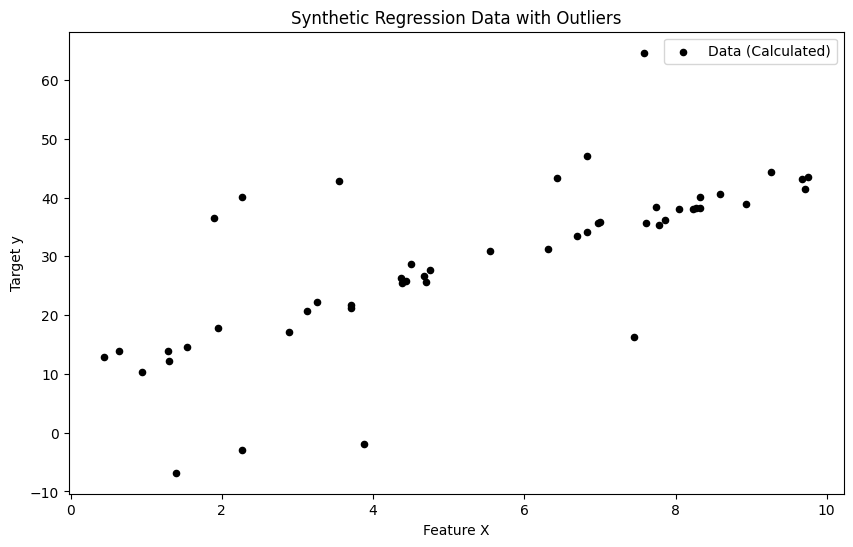

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from machinegnostics.models import GnosticBoostingRegressor
from machinegnostics.metrics import mean_squared_error, r2_score, robr2
from machinegnostics.data import make_regression_check_data

# Generate data
X, y = make_regression_check_data(n_samples=50, outlier_ratio=0.2)

# Visualize proper vs contaminated data
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='black', s=20, label='Data (Calculated)')
plt.title("Synthetic Regression Data with Outliers")
plt.xlabel("Feature X")
plt.ylabel("Target y")
plt.legend()
plt.show()

In [3]:
# Initialize Gnostic Boosting Regressor
# We pass base XGBoost parameters via kwargs if needed (e.g. n_estimators, max_depth)
model = GnosticBoostingRegressor(
    max_iter=5, 
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    verbose=True
)

# Fit the model
print("Training Gnostic Boosting Regressor...")
model.fit(X, y)

# Predict
y_pred = model.predict(X)

# score
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
robr2_score = robr2(y, y_pred)
print("Model Performance:")
print("=" * 40)
print(f"MSE: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"Robust R2 Score: {robr2_score:.4f}")
print("=" * 40)

2026-02-13 17:14:22,222 | GnosticBoostingRegressor | INFO | GnosticBoostingRegressor initialized.
2026-02-13 17:14:22,223 | GnosticBoostingRegressor | INFO | HistoryBoostingBase initialized.
2026-02-13 17:14:22,223 | GnosticBoostingRegressor | INFO | Starting fit process for GnosticBoostingRegressor.
2026-02-13 17:14:22,223 | GnosticBoostingRegressor | INFO | Starting fit input/output processing.
2026-02-13 17:14:22,224 | GnosticBoostingRegressor | INFO | Checking input X of type: <class 'numpy.ndarray'>
2026-02-13 17:14:22,224 | GnosticBoostingRegressor | INFO | Identifying and converting data of type: <class 'numpy.ndarray'>
2026-02-13 17:14:22,224 | GnosticBoostingRegressor | INFO | Checking target y of type: <class 'numpy.ndarray'>
2026-02-13 17:14:22,224 | GnosticBoostingRegressor | INFO | Identifying and converting data of type: <class 'numpy.ndarray'>
2026-02-13 17:14:22,224 | GnosticBoostingRegressor | INFO | Starting fit process for BoostingCalBase.


Training Gnostic Boosting Regressor...


2026-02-13 17:14:22,529 | GnosticBoostingRegressor | INFO | Iteration 1: Loss 0.0010930416129945227, Rentropy 0.15944438705710076
2026-02-13 17:14:22,669 | GnosticBoostingRegressor | INFO | Iteration 2: Loss 30.39927636303679, Rentropy 0.26256109262005156
2026-02-13 17:14:22,802 | GnosticBoostingRegressor | INFO | Iteration 3: Loss 30.73986977719092, Rentropy 0.1791973804257907
2026-02-13 17:14:22,932 | GnosticBoostingRegressor | INFO | Iteration 4: Loss 31.10428848087602, Rentropy 0.1399868067406391
2026-02-13 17:14:23,065 | GnosticBoostingRegressor | INFO | Iteration 5: Loss 31.3494193854564, Rentropy 0.12992456220801327
2026-02-13 17:14:23,065 | GnosticBoostingRegressor | INFO | Making predictions with GnosticBoostingRegressor.
2026-02-13 17:14:23,066 | GnosticBoostingRegressor | INFO | Starting predict input/output processing.
2026-02-13 17:14:23,066 | GnosticBoostingRegressor | INFO | Checking input X for prediction of type: <class 'numpy.ndarray'>
2026-02-13 17:14:23,066 | Gnosti

Model Performance:
MSE: 0.0000
R2 Score: 0.5368
Robust R2 Score: 0.5380


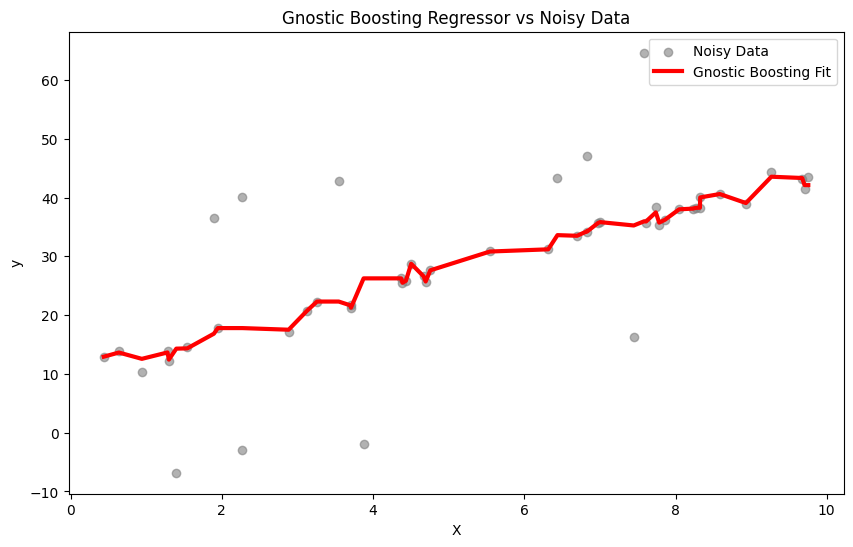

In [4]:
# Sort X for cleaner line plotting
sort_idx = np.argsort(X, axis=0).flatten()
X_sorted = X[sort_idx]
y_pred_sorted = y_pred[sort_idx]

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='gray', alpha=0.6, label='Noisy Data')
plt.plot(X_sorted, y_pred_sorted, color='red', linewidth=3, label='Gnostic Boosting Fit')
plt.title("Gnostic Boosting Regressor vs Noisy Data")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

## Understanding Gnostic Weights

The model assigns lower weights to samples that it deems "unreliable" or "anomalous" (high Gnostic Entropy). Visualizing these weights helps us understand which data points effectively guided the training process.

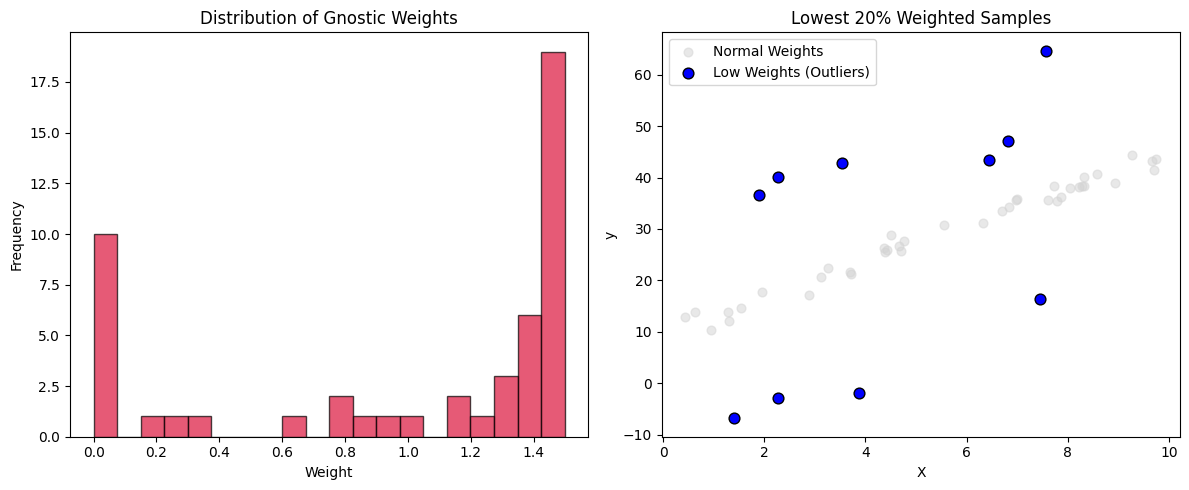

Mean weight: 1.0000
Min weight: 0.0000
Max weight: 1.4983


In [5]:
# Inspect Weights
weights = model.weights

# Visualize weights distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(weights, bins=20, color='crimson', edgecolor='black', alpha=0.7)
plt.title('Distribution of Gnostic Weights')
plt.xlabel('Weight')
plt.ylabel('Frequency')

# Visualize low-weight samples on the dataset
# We use a threshold to identify what the model considers "outliers"
threshold_val = np.percentile(weights, 20) # Bottom 20%
low_weight_mask = weights < threshold_val

plt.subplot(1, 2, 2)
# Plot all points
plt.scatter(X, y, c='lightgray', alpha=0.5, label='Normal Weights', s=40)
# Highlight low weights
plt.scatter(X[low_weight_mask], y[low_weight_mask], c='blue', s=60, edgecolors='k', label='Low Weights (Outliers)')
plt.title(f'Lowest 20% Weighted Samples')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Mean weight: {np.mean(weights):.4f}")
print(f"Min weight: {np.min(weights):.4f}")
print(f"Max weight: {np.max(weights):.4f}")

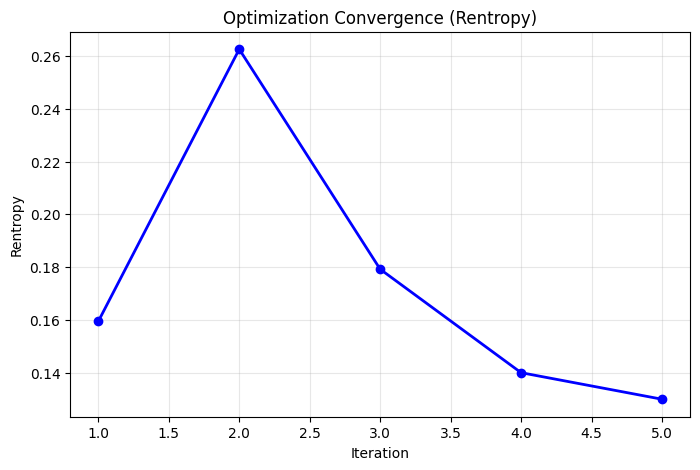

Initial Rentropy: None
Final Rentropy: 0.12992456220801327


In [6]:
history = model._history

if len(history) > 1:
    iterations = [h['iteration'] for h in history if h['iteration'] is not None]
    
    # Plot loss or rentropy
    if 'rentropy' in history[1]:
        metric = 'rentropy'
        title = 'Rentropy'
    else:
        metric = 'cross_entropy_loss'
        title = 'Loss'
        
    values = [h.get(metric, np.nan) for h in history if h['iteration'] is not None]
    
    plt.figure(figsize=(8, 5))
    plt.plot(iterations, values, 'b-o', linewidth=2)
    plt.title(f'Optimization Convergence ({title})')
    plt.xlabel('Iteration')
    plt.ylabel(title)
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Initial {title}: {values[0]}")
    print(f"Final {title}: {values[-1]}")
else:
    print("Model converged in 1 iteration or history not available.")